# <center> Taller Keras $-$ Ejemplo 4

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from time import time

from keras import models
from keras import layers
from tensorflow.keras import optimizers
from keras.models import load_model
from tensorflow.keras.utils import to_categorical

from pandas import DataFrame
from pandas_ml import ConfusionMatrix
from plotmatrix import pretty_plot_confusion_matrix, PlotMatrix

# Introducción a las Redes Convolucionales (ConvNets, CNNs)

__Objetivos:__
* Aprender el funcionamiento básico de una red neuronal convolucional.
* Implementar una CNN simple en Keras para clasificar la base de datos MNIST.

## Base de datos MNIST

Para comprender el funcionamiento de las redes convolucionales, usaremos el ejemplo de clasificar los dígitos de la DB MNIST. En el ejemplo de la red Multicapa alcanzamos una predicción cercano al 97.9%.

In [2]:
# cargar la interfaz a la base de datos que viene con Keras
from keras.datasets import mnist

# lectura de los datos
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

## Redes Convolucionales

![](cnn.png)


![](cnn2.png)

Lo que ahora se guarda dentro de una "neurona" es un filtro convolucional.

![](convfilter.png)

### Reshape (volvemos al formato original)

Para poder entrenar redes convolucionales, los datos de imágenes deben tener un volumen:
$$ volumen = ancho \ (\text{número de filas}) \times alto \ (\text{número de columnas}) \times profundidad \ (\text{número de canales}). $$

Así, los datos deben representarse en forma de un tensor $d-$dimensional.
$$ input\_data = [ancho \ (\text{número de filas}), \ alto \ (\text{número de filas}), \ profundidad \ (\text{número de filas})]. $$

__Ejemplos:__
    
*  Si se quiere hacer un filtro convolucional 1D a una señal 1D de longitud L, se debe representar como un tensor de dimensiones $(L, 1)$.
*  Si se quiere hacer un filtro convolucional 2D a una imagen 2D de tamaño $(m,n)$, se debe representar como un tensor de dimensiones $(m, n, 1)$.
*  Si se quiere hacer un filtro convolucional 2D a una imagen 3D de tamaño $(m,n,3)$, se debe representar como un tensor de dimensiones $(m, n, 3)$.
*  Si se quiere hacer un filtro convolucional 3D a una imagen 3D de tamaño $(m,n,3)$, se debe representar como un tensor de dimensiones $(m, n, 3, 1)$.

Las convnets 2D asumen que los datos de entrada son una colección de imágenes, con tamaño número de renglones por número de columnas y varios canales (que codifican el color). Esto es, los datos deberán estar en formato de tensor de dimensión cuatro de la forma

$$ (\text{num datos} \times \text{num renglones} \times \text{num columnas} \times \text{num canales}). $$

Como las imágenes de MNIST son en niveles de gris (un solo canal) tenemos que agregar una dimensión extra al tensor de datos que corresponde al número de canales y debe ser igual a 1.

### Pre-procesamiento de los datos

In [3]:
# reshape y normalización
train_images = train_images.reshape((-1, 28, 28, 1))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((-1, 28, 28, 1))
test_images = test_images.astype('float32') / 255

data_shape = train_images.shape[1:]

# one-hot encoding
from tensorflow.keras.utils import to_categorical
train_labels = to_categorical(train_labels)
test_labels  = to_categorical(test_labels)

In [4]:
print('train images shape:', train_images.shape)
print('test images shape:', test_images.shape)

print('train labels shape:', train_labels.shape)
print('test labels shape:', test_labels.shape)

# data shape (sin la dimensión del batch_size)
print('data shape:', data_shape)

train images shape: (60000, 28, 28, 1)
test images shape: (10000, 28, 28, 1)
train labels shape: (60000, 10)
test labels shape: (10000, 10)
data shape: (28, 28, 1)


### Etapa de extracción de características mediante una ConvNet

La red propuesta sigue siendo de tipo secuencial. Los datos se procesados por una capa alimentan a la capa siguiente hasta llegar a la capa de salida. Es decir, no hay retroalimentación o recurrencias: que la salida de capa se regrese a una capa previa.

El propósito de la red ConvNet es diseñar los filtros para que dados los parches de imagen de la entrada, reproducir la salida conocida.

La siguiente figura muestra la secuencia de dos etapas (bloques) y cada una corresponde a una subred secuencial.

![](convnet.png)

### Capas convolucionales

El punto importante en aprendizaje profundo, es que aunque hayamos diseñado nuestra red considerando las distintas tareas que se realizarán (extracción de rasgos y clasificación), la red será entrenada en su totalidad. Luego, la división que hemos establecido en el diseño es una referencia, pero la frontera de las tareas será un tanto difusa.

En Keras, una capa convolucional 2D se llama mediante la instrucción _Conv2D_ (hasta ahoara solo habíamos usado Dense y Dropout).

Los parámeros son

__filters:__ Dimensión del espacio de salida: número de filtros de convolución (serán no-lineales debido a la función de activación) que implementará la capa.

Para la primera capa, matemáticamente se escribe $x_2 = \varphi( H^{(i)} \otimes x_1)$, donde $x_1$ es la entradad a la primera capa (los datos), y $x_2$ es la salida (o entrada a la segunda capa). $H^{(i)}$ es el $i$-ésimo filtro de convolución y $\varphi(\cdot)$ es la función de activación (es tensorial y se aplica a cada elemento del tensor que resulta de $H^{(i)} \otimes x_1$).

__kernel_size:__ Dimensiones (renglones y columnas) de los filtros $H^{(i)}$. Si se da un solo valor, significa que son iguales en todas las dimensiones.

__stride:__ Entero o tupla de dos enteros con el paso de convolución en cada dimensión. Por default es 1 en cada dimensión.

__padding:__ {'valid', 'same'} Indica si el resultado tendrá los mismos (num_renglones, num_columnas) que el tensor de entrada o si la convolución solo se aplica sobre datos válidos (con efecto de reducción de bordes). Por default asume el 'valid'.

__data_format:__ {'channels_last', 'channels_first'} indica si los datos de estradad estan en formato (batch_size, image_height, image_width, image_channels) ó (batch_size, image_channels, image_height, image_width). Por default asume el primero.

__dilation_rate:__ Entero o tupla de dos enteros indicando la dilatación de la salida en cada dimensión.

__activation:__ Función de activación.

__use_bias:__ Booleana que indica si se usa vector de sesgo.

__kernel_initializer:__ Método de inicialización de los pesos de la matrix kernel.

__bias_initializer:__ Método de inicialización de los pesos del vector de sesgo.

__kernel_regularizer:__ Método de regularización de los pesos de la matriz kernel.

__bias_regularizer:__ Método de regularización de los pesos del vector de sesgo.

__kernel_constraint:__ Resticción sobre los pesos de la matriz kernel.

__bias_constraint:__ Resticción sobre los pesos del vector de sesgo.

Por ejemplo

    layers.Conv2D(filters=32, kernel_size=(3,3), stride=(1,1), padding='valid', activation='relu', name='name'))

puede escribirse como

    layers.Conv2D(32, kernel_size=(3,3), activation='relu', name='name'))
    
El tensor resultante de una capa de convolución será de (batch_size, image_height, image_width, image_channels=filters). Es decir cada filtro genera ahora una canal (respuesta del filtro

Se espera que:
* la información relevante en forma de relaciones espaciales en la imagen de entrada se codifique en forma de respuesta en algunos canales.
* pixeles vecinos tengas respuestas similares.
* respuestas altas se asocian con filtros entonados a detectar características relevantes.

### Pooling

Ahora, con la finalidad de resaltar la información relevante a la salida de la capa de convolución se aplica un proceso de pooling o agrupado. Esto se realiza mediante la capa _MaxPooling2D_

el formato es

    layers.MaxPooling2D(pool_size=(2,2), strides=None, padding='valid', name='name')

Los parámetros son

__pool_size:__ Entero o tupla indicando las dimensiones de la ventana sobre el que se seleccionará la máxima respuesta.

__strides:__ Entero o tupla indicando el paso (por default es igual a pool_size).

__padding:__ {'valid', 'same'} indica si el resultado tendrá los mismos (num_renglones, num_columnas) que el tensor de entrada o si la convolución solo se aplica sobre datos válidos (con efecto de reducción de bordes). Por default es 'valid'.

__data_format:__ {'channels_last' (default), 'channels_first'}.

Por ejemplo

    convNN.add(layers.MaxPooling2D(pool_size=(2,2), name='name'))

Un resultado inmediato de la capa de Pooling es la reducción de la dimensión de los datos. Esto permite que conforme se avanza en la red la información se concentra en un espacio de dimensión menor.

Los usual es añadir capas de Pooling entre las capas de convolución. Por ejemplo

    convNN.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    convNN.add(layers.MaxPooling2D(pool_size=(2, 2)))
    convNN.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))

A continuación definimos una red neuronal convolucional (CNN).

__Ejercicio:__ Defina un modelo de red convolucional convNet, con tres capas convolucionales _Conv2D_. El número de filtros de esas capas debe ser 32, 32 y 64. Use un kernel_size = (3,3), y funciones de activación ReLU. (stride=1 y padding='valid')

Intercale entre las capas convolucionales, capas _MaxPooling2D_. Use un pool_size = (2,2).

Asegúrese que las capas tienen nombres distintos, e incluya el parámetro input_shape en la primer capa.

In [5]:
# if 'convnet' in globals(): del convet

### START CODE HERE ### (≈ 5 lines of code)
convnet = models.Sequential()

convnet = models.Sequential([
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=data_shape, strides=(1, 1), padding='valid', name='conv1'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', strides=(1, 1), padding='valid', name='conv2'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', strides=(1, 1), padding='valid', name='conv3')
])
### END CODE HERE ###

In [6]:
convnet.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 11, 11, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
conv3 (Conv2D)               (None, 3, 3, 64)          18496     
Total params: 28,064
Trainable params: 28,064
Non-trainable params: 0
_________________________________________________________________


La estrategia es ir transformando la información espacial en detección (respuesta) de filtros. Así, las dimensiones del tensor que se procesa se irán estrechando espacialmente a la vez que se añaden mas capas (filtros).

Las respuestas de la última capa se pueden entender como las características extraídas del vector de entrada.

La siguiente etapa es alimentar con las características extraídas una red multicapa para realizar la clasificación.

### Etapa de clasificación mediante una red multicapa

El primer paso es pasar el tensor de rasgos calculado por la etapa previa a un vector unidimensional. Esto lo hacemos con la capa _Flatten_, cuya definición esta dada por

    layers.Flatten(data_format=None, name='name')

que no requiere ningún parámetro.

Ahora agregamos una red con una arquitectura similar a la que usamos para clasificar los dígitos MNIST. La etapa se compone con varias capas Dense, y la de salida es un vector de dimesión 10. Sólo que ahora, en la primera capa oculta pondremos menos neuronas, pues los rasgos relevantes se han conservado y la información no relevante habre de haberse desechado.

__Ejercicio:__ Agregue una capa _Flatten_ a la red convolucional \texttt{convnet} anterior.

Luego, agregue una capas oculta _Dense_ con 64 neuronas, y una capa de salida _Dense_ con 10 neuronas. Use funciones de activación ReLU (y softmax en la capa de salida).

In [7]:
### START CODE HERE ### (≈ 3 lines of code)
convnet.add(layers.Flatten(data_format=None, name = 'flatten'))
convnet.add(layers.Dense(64, activation='relu', name='dense2'))
convnet.add(layers.Dense(10,  activation='softmax', name='output_layer'))
### END CODE HERE ###

In [8]:
convnet.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 11, 11, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
conv3 (Conv2D)               (None, 3, 3, 64)          18496     
_________________________________________________________________
flatten (Flatten)            (None, 576)               0         
_________________________________________________________________
dense2 (Dense)               (None, 64)               

Como podemos ver, el número de parámetros totales a entrenar es sustancialmente menor que la red multicapa (más de 400 mil y 800 mil).

Compilamos en modelo, que es definir los parámetros de la etapa de entrenamiento.

### Entrenamiento

In [9]:
opt = optimizers.RMSprop(lr=0.001)
convnet.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

c:\Users\juanq\anaconda3\envs\keras\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [10]:
history = convnet.fit(train_images, train_labels, epochs=5, batch_size=128, validation_split=0.16666)

Epoch 1/5
391/391 [==============================] - 17s 42ms/step - loss: 0.2914 - accuracy: 0.9088 - val_loss: 0.1177 - val_accuracy: 0.9650
Epoch 2/5
391/391 [==============================] - 27s 68ms/step - loss: 0.0724 - accuracy: 0.9778 - val_loss: 0.0649 - val_accuracy: 0.9808
Epoch 3/5
391/391 [==============================] - 28s 70ms/step - loss: 0.0479 - accuracy: 0.9852 - val_loss: 0.0463 - val_accuracy: 0.9867
Epoch 4/5
391/391 [==============================] - 26s 67ms/step - loss: 0.0358 - accuracy: 0.9888 - val_loss: 0.0452 - val_accuracy: 0.9869
Epoch 5/5
391/391 [==============================] - 22s 56ms/step - loss: 0.0288 - accuracy: 0.9910 - val_loss: 0.0426 - val_accuracy: 0.9882


### Si lo anterior demora mucho tiempo

In [28]:
# borrar la red
if 'convnet' in globals(): del convnet

# cargar la red ya entrenada
convnet = load_model('convnet.h5')
convnet.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 26, 26, 32)        320       
_________________________________________________________________
maxpool1 (MaxPooling2D)      (None, 13, 13, 32)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 11, 11, 32)        9248      
_________________________________________________________________
maxpool2 (MaxPooling2D)      (None, 5, 5, 32)          0         
_________________________________________________________________
conv3 (Conv2D)               (None, 3, 3, 64)          18496     
_________________________________________________________________
flatten (Flatten)            (None, 576)               0         
_________________________________________________________________
dense (Dense)                (None, 64)               

### Evaluando resultados

In [29]:
results = convnet.evaluate(test_images, test_labels)
print('test loss:', results[0], 'WOW!')
print('test accuracy:', results[1], 'Otro WOW!')

212/313 [===================>..........] - ETA: 0s - loss: 0.0377 - accuracy: 0.9888

313/313 [==============================] - 1s 4ms/step - loss: 0.0291 - accuracy: 0.9916
test loss: 0.029072115197777748 WOW!
test accuracy: 0.991599977016449 Otro WOW!


Mientras la red multicapa alcanzó un 97.8% de precisión, la red convolucional llegó 99.16%.

### Ver el historial de desempeño de la red

In [30]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

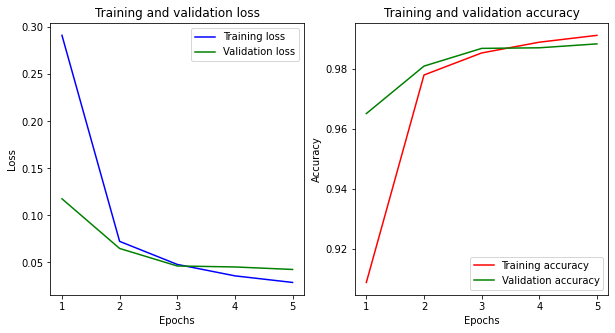

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

# figure
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'g', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Resultados

In [32]:
pred = convnet.predict(test_images)
predictions = np.argmax(pred, 1)

In [33]:
test_labs = np.argmax(test_labels, 1)
confusion_matrix = ConfusionMatrix(test_labs, predictions)

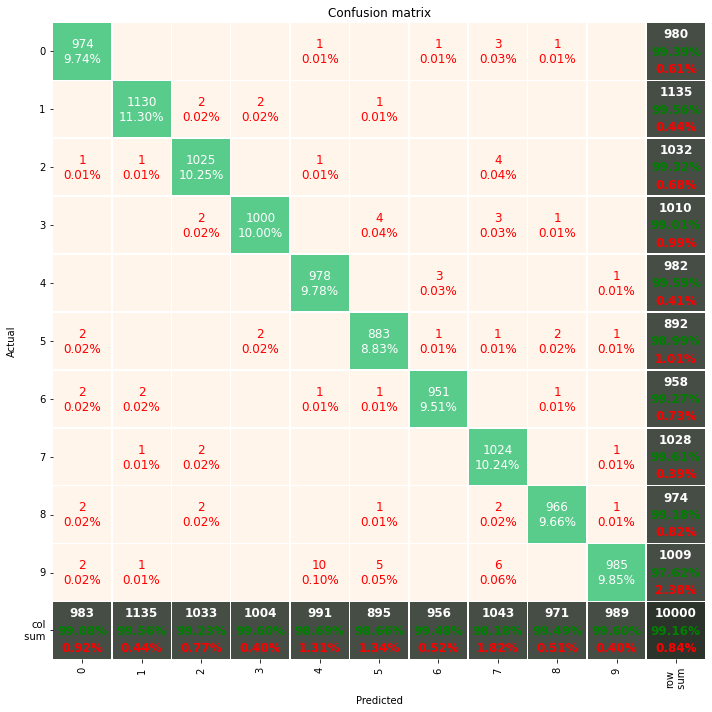

In [34]:
# plot confusion matrix
CM = confusion_matrix.to_array()
cf = DataFrame(CM)
pretty_plot_confusion_matrix(cf, annot=True, pred_val_axis='x', figsize=(10,10), fz=12)

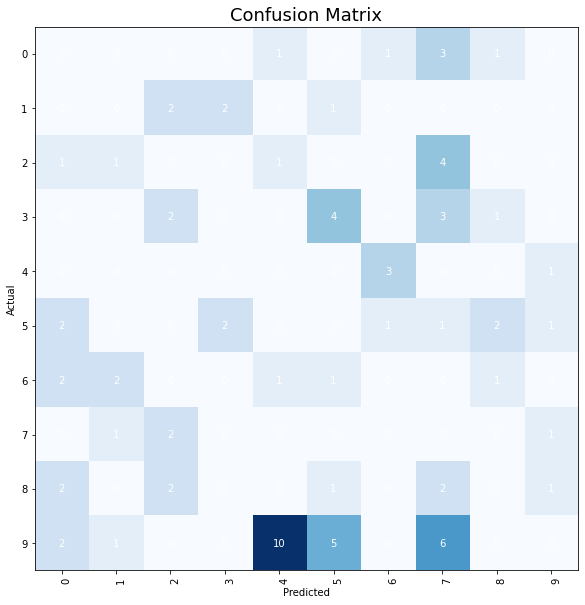

In [35]:
# other plot
PlotMatrix(CM, figsize=(10,10), cmap=plt.cm.Blues, title='Confusion Matrix', fz=15)

In [36]:
# save model
#convnet.save('convnet.h5')

---

---

### ¿Qué está aprendiendo la red?

A continuación vamos a visualizar el contenido de los filtros que la red está aprendiendo en la primer capa.

In [37]:
# extraer la lista con los pesos aprendidos
W = convnet.get_weights()

In [38]:
# lista de los tamaños (shapes) de cada matriz de parámetros:
# W = pesos, b = bias
for i in range(0, len(W)):
    if (i%2 ==0): print('capa W' + str(i//2) + ':', W[i].shape)
    else: print('capa b' + str(i//2) + ':', W[i].shape)

capa W0: (3, 3, 1, 32)
capa b0: (32,)
capa W1: (3, 3, 32, 32)
capa b1: (32,)
capa W2: (3, 3, 32, 64)
capa b2: (64,)
capa W3: (576, 64)
capa b3: (64,)
capa W4: (64, 10)
capa b4: (10,)


In [39]:
# capturamos los filtros en la primer capa
filtros = W[0].reshape(3, 3, 32)

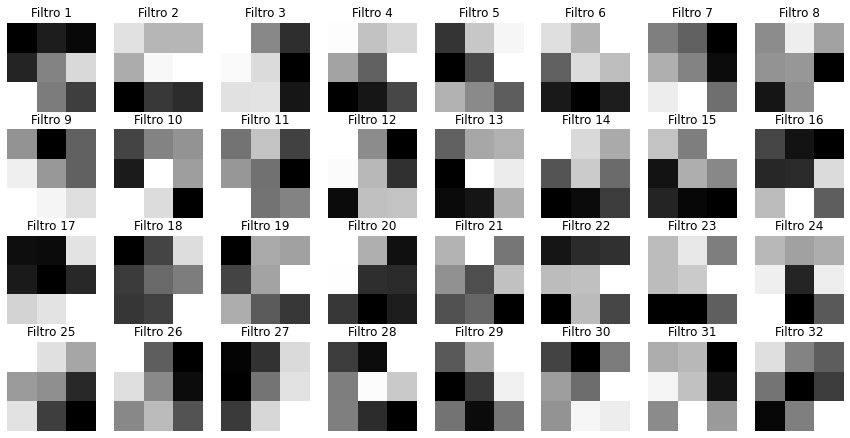

In [40]:
# plot
plt.figure(figsize=(15,7.5))
plt.rcParams.update({'font.size': 10})
for i in range(0, 32):
    plt.subplot(4, 8, i+1)
    plt.imshow(filtros[:,:,i], cmap='gray')
    plt.title('Filtro ' + str(i+1))
    plt.axis('off')
plt.show()

Si queremos ver qué le hace cada uno de estos filtros a una imagen, debemos pedirle a la red que muestre la salida de la primer capa.

Una forma simple de hacer esto es crear una nueva red, y agregarle a ésta sólo la capa 1 de la convNet.

In [41]:
# construimos una red conteniendo sólo la primer capa de 'convnet'
capa1 = models.Sequential()
capa1.add(convnet.get_layer('conv1'))
capa1.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 26, 26, 32)        320       
Total params: 320
Trainable params: 320
Non-trainable params: 0
_________________________________________________________________


In [42]:
# número entre 0 y 9,999 para seleccionar una imagen de prueba
idx = 300

# aplicar la capa1 a la imagen
filtered_image = capa1.predict(test_images[idx:idx+1])

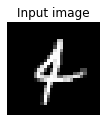

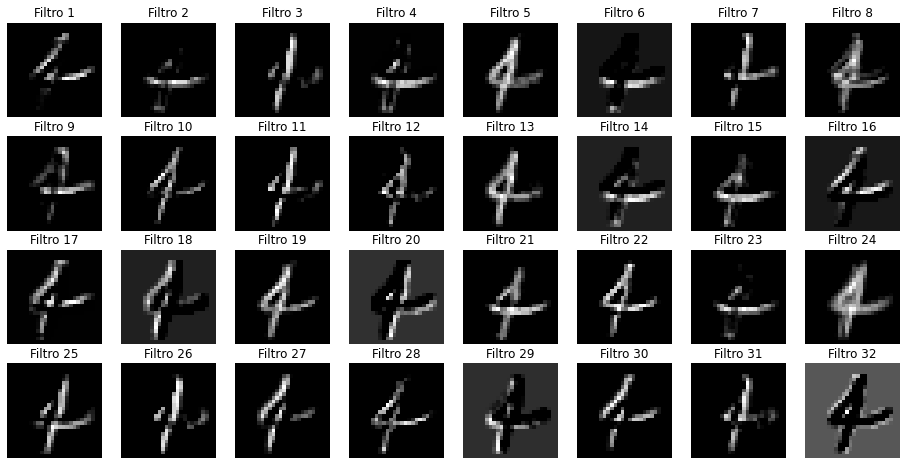

In [43]:
# plot
plt.figure(figsize=(1.7,1.7))
plt.rcParams.update({'font.size': 10})
plt.imshow(test_images[idx,:,:,0], cmap='gray')
plt.title('Input image')
plt.axis('off')
plt.show()

plt.figure(figsize=(16,8))
plt.rcParams.update({'font.size': 10})
for i in range(0, 32):
    plt.subplot(4, 8, i+1)
    plt.imshow(filtered_image[0,:,:,i], cmap='gray')
    plt.title('Filtro ' + str(i+1))
    plt.axis('off')
plt.show()

Si queremos ver ahora la segunda capa de filtros

In [44]:
# construimos otra red conteniendo has la segunda capa de filtros de 'convnet'
capa3 = models.Sequential()
capa3.add(convnet.get_layer('conv1'))
capa3.add(convnet.get_layer('maxpool1'))
capa3.add(convnet.get_layer('conv2'))
capa3.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 26, 26, 32)        320       
_________________________________________________________________
maxpool1 (MaxPooling2D)      (None, 13, 13, 32)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 11, 11, 32)        9248      
Total params: 9,568
Trainable params: 9,568
Non-trainable params: 0
_________________________________________________________________


In [45]:
# número entre 0 y 9,999 para seleccionar una imagen de prueba
idx = 300

# aplicar la capa3 a la imagen
filtered_image2 = capa3.predict(test_images[idx:idx+1])

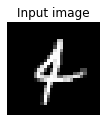

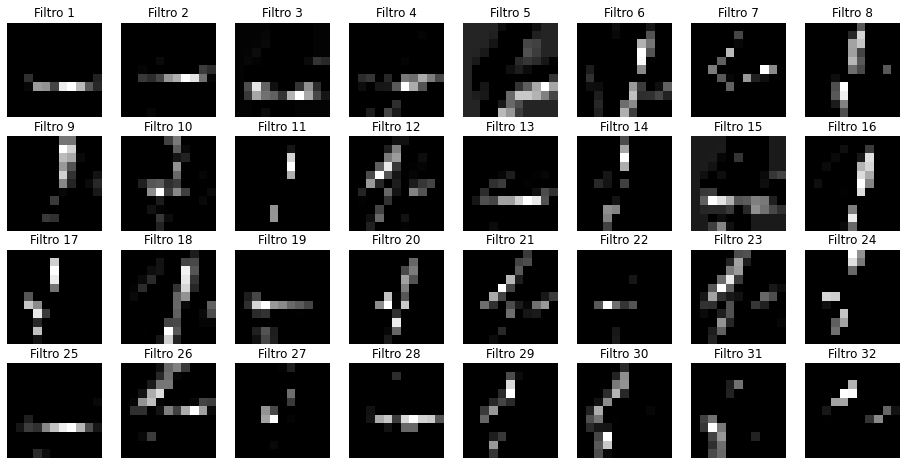

In [46]:
# plot
plt.figure(figsize=(1.7,1.7))
plt.rcParams.update({'font.size': 10})
plt.imshow(test_images[idx,:,:,0], cmap='gray')
plt.title('Input image')
plt.axis('off')
plt.show()

plt.figure(figsize=(16,8))
plt.rcParams.update({'font.size': 10})
for i in range(0, 32):
    plt.subplot(4, 8, i+1)
    plt.imshow(filtered_image2[0,:,:,i], cmap='gray')
    plt.title('Filtro ' + str(i+1))
    plt.axis('off')
plt.show()

---

---